In [1]:
import sys
sys.path.append('..')
from src.kitti import *
import numpy as np
import cv2
%matplotlib inline

Read frame transformations from KITTI sequence 00 into a list of frames (frame).

In [2]:
IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
   
def transform3(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[i] = np.dot(points[i], poses[i].T)
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = + pmin[1] / maxxy

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Compute the frame positions by mutiplying every point by a sequence of their transformations
vectorized to improve speed

In [40]:
sequence = 9

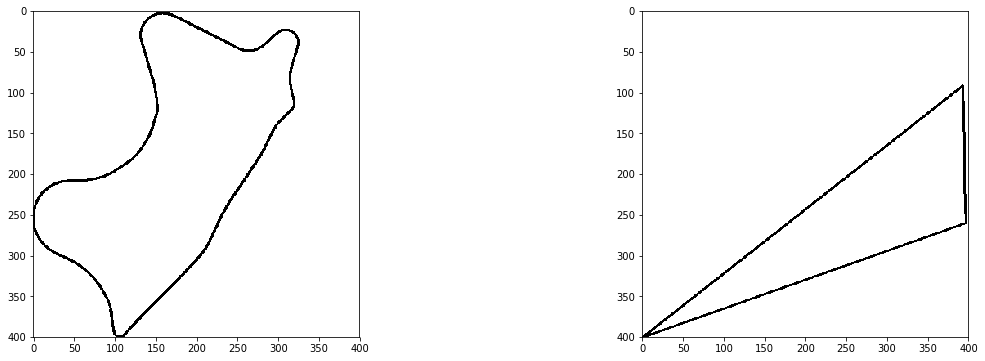

In [41]:
folder = '/data/urbinn/datasets/urb_trajectory_output'
#folder = '/home/jeroen/notebooks/urb/resultsba'
keyframeids, frameids, poses = load(folder + '/keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))

posesold = poses
points = transform(poses[:])
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
pointsgt = transform2(gt)[:]
coordsgt = plot_trajectory3(pointsgt)
show2(draw(coordsgt, new_image()), p)

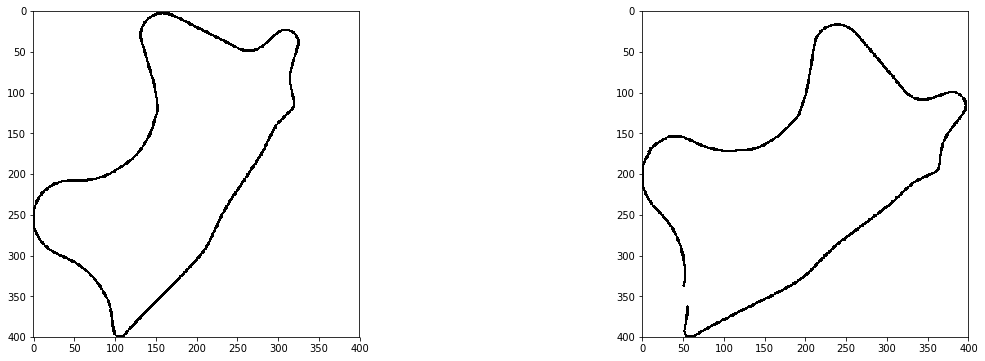

In [42]:
folder = '/data/urbinn/datasets/urb_trajectory_rotationfixed'
folder = '/home/jeroen/notebooks/urb/resultsba'
keyframeids, frameids, poses = load(folder + '/keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))

posesnew = poses
points = transform(poses[:])
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
pointsgt = transform2(gt)[:]
coordsgt = plot_trajectory3(pointsgt)
show2(draw(coordsgt, new_image()), p)

In [6]:
for i, xy in enumerate(coords):
    print(i, xy[0], xy[1])

0 181.88731674 369.624016646
1 181.943927645 369.147550775
2 181.994087178 368.652480058
3 182.042748135 368.150130671
4 182.089762944 367.627430885
5 182.140091341 367.096599592
6 182.186496096 366.551015248
7 182.231531417 365.994210305
8 182.275404178 365.42907504
9 182.320845428 364.857269704
10 182.363250237 364.273313049
11 182.40611747 363.687322417
12 182.443074882 363.093793169
13 182.489602205 362.499403072
14 182.532342427 361.898945265
15 182.573732422 361.291222478
16 182.610385289 360.677563818
17 182.644612751 360.044741069
18 182.682877441 359.414724856
19 182.719152751 358.777928201
20 182.756430877 358.139354656
21 182.795861292 357.491383879
22 182.836694632 356.841049141
23 182.874691308 356.191684223
24 182.910905845 355.528230723
25 182.947127074 354.864234735
26 182.975652497 354.189836798
27 183.011946025 353.521081957
28 183.045867661 352.839343397
29 183.085130619 352.159754062
30 183.124509946 351.47112169
31 183.159949602 350.780635648
32 183.19970304 350.09

1241 131.377407185 200.870825259
1242 131.537299221 200.545336156
1243 131.679837964 200.211064333
1244 131.809458769 199.872528741
1245 131.925911366 199.527470896
1246 132.040485941 199.180715589
1247 132.142237302 198.82431683
1248 132.242440607 198.472848027
1249 132.348222386 198.121789811
1250 132.453066542 197.774242134
1251 132.559893023 197.426066734
1252 132.65960428 197.080064581
1253 132.763483944 196.736639742
1254 132.875982881 196.398219726
1255 132.995055145 196.065928309
1256 133.118184945 195.735400637
1257 133.247228398 195.414543434
1258 133.384176361 195.095065641
1259 133.531510879 194.792240773
1260 133.689745904 194.509126438
1261 133.868546262 194.254206352
1262 134.043378468 194.025824121
1263 134.214617344 193.811721927
1264 134.389511407 193.599902341
1265 134.57745231 193.389827233
1266 134.785469297 193.196844662
1267 135.01455795 193.034628697
1268 135.253129676 192.899181357
1269 135.490889801 192.774807498
1270 135.729479523 192.664742053
1271 135.97426

2419 250.543991087 221.186748644
2420 250.12419088 221.164454351
2421 249.710299595 221.138621059
2422 249.290592662 221.116160456
2423 248.876859479 221.063307181
2424 248.473995095 220.994193348
2425 248.070926544 220.912899069
2426 247.667766375 220.823939032
2427 247.273575146 220.715117739
2428 246.884494636 220.588465313
2429 246.515438064 220.446988425
2430 246.152537107 220.285102555
2431 245.799034417 220.093372714
2432 245.460194395 219.874698772
2433 245.125512752 219.633955006
2434 244.812785912 219.367884797
2435 244.527727625 219.082468631
2436 244.254278111 218.779341502
2437 244.006570768 218.47894558
2438 243.754218188 218.153364664
2439 243.524003255 217.80562478
2440 243.314680081 217.433886582
2441 243.119207112 217.040890158
2442 242.934065218 216.634008135
2443 242.762495539 216.216403513
2444 242.615971992 215.783707698
2445 242.496535948 215.349828531
2446 242.37531417 214.885410316
2447 242.274487279 214.417680107
2448 242.200640449 213.940632197
2449 242.13761

3617 179.597932168 155.734414002
3618 179.506331068 154.812596237
3619 179.426776087 153.905598254
3620 179.333457922 152.985940723
3621 179.245167722 152.078817277
3622 179.157089887 151.16842627
3623 179.06423304 150.251105839
3624 178.977355383 149.353521752
3625 178.89407526 148.437248644
3626 178.811927034 147.527128526
3627 178.737537093 146.648754632
3628 178.65715615 145.750386326
3629 178.575310389 144.84499133
3630 178.496150412 143.948957379
3631 178.411617494 143.045959386
3632 178.331735657 142.155012674
3633 178.257606797 141.258764974
3634 178.176271021 140.377744493
3635 178.101552535 139.502031688
3636 178.022538031 138.637574615
3637 177.941872968 137.775033593
3638 177.858548023 136.919893415
3639 177.776006059 136.080236945
3640 177.688938272 135.254080997
3641 177.600406502 134.434523033
3642 177.517027296 133.634994273
3643 177.442453933 132.853576716
3644 177.361634427 132.077990585
3645 177.282774381 131.306039063
3646 177.208289441 130.552816833
3647 177.134867

In [7]:
p = posesold.copy()
for i in range(1, len(p)):
    p[i] = np.dot( p[i-1], p[i] )
pterug = p.copy()
for i in range(len(p)-1, 0, -1):
    pterug[i] = np.dot( np.linalg.pinv(pterug[i-1]), pterug[i] )

print(posesold[:,2,3])
pterug[:,2,3]

[ 0.         -4.72404789 -4.66483477 ..., -3.64604213 -3.49783966
 -2.30657875]


array([ 0.        , -4.72404789, -4.66483477, ..., -3.64604213,
       -3.49783966, -2.30657875])

Show the affine world coodinates for the first 3 poses

In [8]:
points[:3]

array([[-21.35430772,  21.14676749, -72.94175367,   1.        ],
       [-21.27335182,  21.1167105 , -72.26038808,   1.        ],
       [-21.20162165,  21.08754585, -71.55241679,   1.        ]])

show the converted x,y coordinates to plot the trajectory

In [9]:
coords[:3]

[[181.88731674029293, 369.62401664633774],
 [181.94392764540873, 369.14755077467197],
 [181.99408717807452, 368.65248005822559]]

In [10]:
show(draw_frame(frame[3281]))

NameError: name 'frame' is not defined